In [2]:
# compatibilité python 2 et python 3
from __future__ import division, print_function, unicode_literals

# imports
import numpy as np
import os

# stabilité du notebook d'une exécution à l'autre
np.random.seed(42)

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# ignorer les warnings inutiles (voir SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import os
import tarfile
from six.moves import urllib
import pandas as pd

EMPLOYEES_PATH = os.path.join("datasets", "employees")
TILME_PATH = os.path.join("datasets", "time")

def load_general_data(employees_path=EMPLOYEES_PATH):
    general_csv_path = os.path.join(employees_path, "general_data.csv")
    return pd.read_csv(general_csv_path)

def load_employees_data(employees_path=EMPLOYEES_PATH):
    employee_csv_path = os.path.join(employees_path, "employee_survey_data.csv")
    return pd.read_csv(employee_csv_path)

def load_manager_data(employees_path=EMPLOYEES_PATH):
    manager_csv_path = os.path.join(employees_path, "manager_survey_data.csv")
    return pd.read_csv(manager_csv_path)

def load_time_in_data(time_path=TILME_PATH):
    time_in_csv_path = os.path.join(time_path, "in_time.csv")
    return pd.read_csv(time_in_csv_path)

def load_time_out_data(time_path=TILME_PATH):
    time_out_csv_path = os.path.join(time_path, "out_time.csv")
    return pd.read_csv(time_out_csv_path)

# Loading all the data
general_df = load_general_data()
employees_df = load_employees_data()
manager_df = load_manager_data()
time_in_df = load_time_in_data()
time_out_df = load_time_out_data()

# Add EmployeeID column name
time_in_df.rename( columns={'Unnamed: 0':'EmployeeID'}, inplace=True )
time_out_df.rename( columns={'Unnamed: 0':'EmployeeID'}, inplace=True )

# Transform True/False string to 1:0
general_df['Attrition'] = general_df['Attrition'].map({'Yes': 1, 'No': 0})

# Merging surveys and general dataframes
merged_df = pd.merge(general_df, employees_df, on='EmployeeID')
merged_df = pd.merge(merged_df, manager_df, on='EmployeeID')

merged_df["GlobalSatisfaction"] = (merged_df["EnvironmentSatisfaction"] + merged_df["JobSatisfaction"] + merged_df["WorkLifeBalance"]) / 3
merged_df["GlobalPerformance"] = (merged_df["JobInvolvement"] + merged_df["PerformanceRating"]) / 2

C:\Users\amaturel\AppData\Local\Temp\ipykernel_25300\2889711764.py:26: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
merged_df

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,GlobalSatisfaction,GlobalPerformance
0,51,0,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1,0,0,3.0,4.0,2.0,3,3,3.000000,3.0
1,31,1,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,5,1,4,3.0,2.0,4.0,2,4,3.000000,3.0
2,32,0,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5,0,3,2.0,2.0,1.0,3,3,1.666667,3.0
3,38,0,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,8,7,5,4.0,4.0,3.0,2,3,3.666667,2.5
4,32,0,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,6,0,4,4.0,1.0,3.0,3,3,2.666667,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,0,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,3,0,2,4.0,1.0,3.0,3,3,2.666667,3.0
4406,29,0,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,3,0,2,4.0,4.0,3.0,2,3,3.666667,2.5
4407,25,0,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,4,1,2,1.0,3.0,3.0,3,4,2.333333,3.5
4408,42,0,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,9,7,8,4.0,1.0,3.0,2,3,2.666667,2.5


In [2]:
# Convert string columns to datetime, handling None as NaT automatically
for col in time_in_df.columns[1:]:  # Skip 'EmployeeID' column
    time_in_df[col] = pd.to_datetime(time_in_df[col], errors='coerce')
    time_out_df[col] = pd.to_datetime(time_out_df[col], errors='coerce')

# Initialize a DataFrame to store the difference between in and out time
time_diff_df = time_in_df.copy()
for col in time_in_df.columns[1:]:  # Again, skip 'EmployeeID'
    time_diff_df[col] = time_out_df[col] - time_in_df[col]
    # Replace NaT with timedelta of zero
    time_diff_df[col] = time_diff_df[col].fillna(pd.Timedelta(seconds=0))

df_converted = time_diff_df.apply(lambda x: x.dt.total_seconds() / 3600 if x.dtype == 'timedelta64[ns]' else x)

# Calculate the sum of work durations for each employee
total_duration = df_converted.drop(columns='EmployeeID').sum(axis=1)
total_variance = df_converted.drop(columns='EmployeeID').var(axis=1)
total_absence = df_converted.drop(columns='EmployeeID').isin([0]).sum(axis=1)

# Calculate the number of datetime columns without the EmployeeID column
num_datetime_columns = len(time_diff_df.columns) - 1

# Calculate the average presence time per employee
average_presence_time = total_duration / num_datetime_columns
average_variance = total_variance / num_datetime_columns
absence = total_absence

# Attach the results to the original EmployeeID
average_presence_df = pd.DataFrame({
    'EmployeeID': time_diff_df['EmployeeID'],
    'AveragePresence': average_presence_time,
    'VariancePresence': average_variance
})

merged_df = merged_df.merge(average_presence_df, left_on='EmployeeID', right_on='EmployeeID')

merged_df.describe()

,Age,Attrition,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,...,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,GlobalSatisfaction,GlobalPerformance,AveragePresence,VariancePresence
count,4410.000000,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,...,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.000000,4327.000000,4410.000000,4410.000000,4410.000000
mean,36.923810,0.161224,9.192517,2.912925,1.0,2205.500000,2.063946,65029.312925,2.694830,15.209524,...,4.123129,2.723603,2.728246,2.761436,2.729932,3.153741,2.737000,2.941837,6.978070,0.020002
std,9.133301,0.367780,8.105026,1.023933,0.0,1273.201673,1.106689,47068.888559,2.498887,3.659108,...,3.567327,1.092756,1.101253,0.706245,0.711400,0.360742,0.568256,0.400536,1.269584,0.007253
min,18.000000,0.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,2.000000,5.167828,0.008247
25%,30.000000,0.000000,2.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.333333,2.500000,5.990699,0.014807
50%,36.000000,0.000000,7.000000,3.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.666667,3.000000,6.688821,0.018418
75%,43.000000,0.000000,14.000000,4.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,...,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000,3.333333,3.000000,7.537530,0.023469
max,60.000000,1.000000,29.000000,5.000000,1.0,4410.000000,5.000000,199990.000000,9.000000,25.000000,...,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,10.434399,0.048186


In [3]:
for col in merged_df:
    print(col)
    print(merged_df[col].unique())

Age
[51 31 32 38 46 28 29 25 45 36 55 47 37 21 35 26 50 53 42 44 49 18 41 39
 58 33 43 52 27 30 54 40 23 48 57 34 24 22 56 60 19 20 59]
Attrition
[0 1]
BusinessTravel
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department
['Sales' 'Research & Development' 'Human Resources']
DistanceFromHome
[ 6 10 17  2  8 11 18  1  7 28 14  3  4 16  9  5 20 29 15 13 24 19 22 25
 21 26 27 12 23]
Education
[2 1 4 5 3]
EducationField
['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
EmployeeCount
[1]
EmployeeID
[   1    2    3 ... 4408 4409 4410]
Gender
['Female' 'Male']
JobLevel
[1 4 3 2 5]
JobRole
['Healthcare Representative' 'Research Scientist' 'Sales Executive'
 'Human Resources' 'Research Director' 'Laboratory Technician'
 'Manufacturing Director' 'Sales Representative' 'Manager']
MaritalStatus
['Married' 'Single' 'Divorced']
MonthlyIncome
[131160  41890 193280 ...  37020  23980  54680]
NumCompaniesWorked
[ 1.  0.  3.  4.  2.  7.  9.  5.  6.  8. nan]
Over1

In [4]:
unethical_cols = ["Age", "MaritalStatus", "Gender", "EmployeeID"]
merged_df = merged_df.drop(unethical_cols, axis=1)

In [5]:
data_corr = merged_df.corr(numeric_only=True)
abs(data_corr["Attrition"]).sort_values(ascending=False)

Attrition                  1.000000
AveragePresence            0.198890
VariancePresence           0.172763
TotalWorkingYears          0.170338
GlobalSatisfaction         0.158194
YearsWithCurrManager       0.156199
YearsAtCompany             0.134392
JobSatisfaction            0.102847
EnvironmentSatisfaction    0.102142
WorkLifeBalance            0.062756
TrainingTimesLastYear      0.049431
NumCompaniesWorked         0.042345
YearsSinceLastPromotion    0.033019
PercentSalaryHike          0.032533
MonthlyIncome              0.031176
PerformanceRating          0.023403
JobInvolvement             0.015588
Education                  0.015111
JobLevel                   0.010290
DistanceFromHome           0.009730
StockOptionLevel           0.006839
GlobalPerformance          0.003304
EmployeeCount                   NaN
StandardHours                   NaN
Name: Attrition, dtype: float64

In [6]:
data = merged_df.drop(["Attrition"], axis=1)
data_labels = merged_df["Attrition"].copy()

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_correlated_cols = ["AveragePresence"]

general_numerical = data.select_dtypes(include=[np.number])
#general_numerical = general_numerical.drop(num_correlated_cols, axis=1)
numerical_attribs = list(general_numerical)

general_gategoric = data.select_dtypes(include=[object])
categoric_attribs = list(general_gategoric)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant", fill_value="missing")),
        ('ordinal', OrdinalEncoder()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_attribs),
        ("cat", cat_pipeline, categoric_attribs)
    ],
    remainder='passthrough')

data_prepared = full_pipeline.fit_transform(data)

In [7]:
data_df = pd.DataFrame(data_prepared, columns=data.columns)
data_prepared_df = data_df.copy()

In [8]:
data_prepared_df = pd.concat([data_labels, data_prepared_df], axis=1)

data_corr = data_prepared_df.corr(numeric_only=True)
abs(data_corr["Attrition"]).sort_values(ascending=False)

Attrition                  1.000000
WorkLifeBalance            0.198890
JobInvolvement             0.172763
NumCompaniesWorked         0.170162
EnvironmentSatisfaction    0.156722
StockOptionLevel           0.156199
PercentSalaryHike          0.134392
TrainingTimesLastYear      0.103068
TotalWorkingYears          0.101625
YearsAtCompany             0.062975
GlobalPerformance          0.057940
Over18                     0.049431
GlobalSatisfaction         0.048206
EmployeeCount              0.042064
StandardHours              0.033019
JobLevel                   0.032533
EducationField             0.031176
AveragePresence            0.025809
YearsWithCurrManager       0.023403
YearsSinceLastPromotion    0.015588
Department                 0.015111
Education                  0.010290
BusinessTravel             0.009730
MonthlyIncome              0.006839
JobSatisfaction            0.003304
PerformanceRating          0.000074
DistanceFromHome                NaN
JobRole                     

In [9]:
data_prepared_df.head()

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,JobLevel,JobRole,MonthlyIncome,...,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,GlobalSatisfaction,GlobalPerformance,AveragePresence,VariancePresence
0,0,-0.393938,-0.891688,0.0,-0.961486,1.405136,-0.678464,-1.150554,0.0,-0.932014,...,-0.426230,0.469575,0.145230,-0.333780,0.127512,2.0,2.0,1.0,0.0,0.0
1,1,0.099639,-1.868426,0.0,-0.961486,-0.491661,-1.079486,2.129306,0.0,0.241988,...,2.346151,0.469575,0.145230,0.001208,0.025647,1.0,1.0,1.0,6.0,0.0
2,0,0.963398,1.061787,0.0,1.749610,2.725053,-0.678464,-0.057267,0.0,2.589994,...,-0.426230,-1.899115,0.145230,-0.374474,-0.949902,1.0,1.0,4.0,7.0,0.0
3,0,-0.887515,2.038524,0.0,0.845911,0.386301,0.123580,-1.150554,0.0,2.589994,...,-0.426230,1.653921,-1.103239,-0.394665,-0.258083,0.0,1.0,1.0,1.0,0.0
4,0,0.099639,-1.868426,0.0,-0.961486,-0.884109,0.524602,-0.877232,0.0,1.415991,...,-0.426230,-0.122597,0.145230,0.423261,-0.757098,2.0,1.0,3.0,7.0,0.0


In [10]:
X = data_prepared_df.drop("Attrition", axis=1)  # Features
y = data_prepared_df["Attrition"]  # Labels

from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train, test in splitter.split(X, y):
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

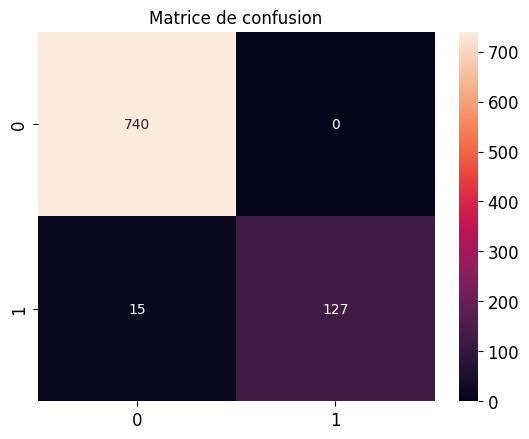

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, roc_curve, confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title('Matrice de confusion')
plt.show()

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       740
           1       1.00      0.89      0.94       142

    accuracy                           0.98       882
   macro avg       0.99      0.95      0.97       882
weighted avg       0.98      0.98      0.98       882



In [14]:
y_proba = clf.predict_proba(X_test)[:, 1]  # Get probabilities of the positive class

auc_score = roc_auc_score(y_test, y_proba)
auc_score

0.9951037304910545